In [1]:
import os
import numpy as np
import pandas as pd
import lightgbm as lgb
from tsforest.forecaster import LightGBMForecaster

import matplotlib.pyplot as plt
import seaborn as sns

/home/turing/miniconda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



***

In [2]:
def reduce_mem_usage(df, verbose=False):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                #if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                #    df[col] = df[col].astype(np.float16)
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: 
        print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

***

In [3]:
data = (pd.read_parquet("../input/train_dataframe.parquet")
        .dropna()
        .reset_index(drop=True)
        .rename({"q":"y"}, axis=1)
       )

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39635116 entries, 0 to 39635115
Data columns (total 25 columns):
 #   Column         Dtype         
---  ------         -----         
 0   ts_id          int16         
 1   item_id        int16         
 2   dept_id        int8          
 3   cat_id         int8          
 4   store_id       int8          
 5   state_id       int8          
 6   y              float32       
 7   ds             datetime64[ns]
 8   event_name_1   int8          
 9   event_type_1   int8          
 10  event_name_2   int8          
 11  event_type_2   int8          
 12  sell_price     float32       
 13  regular_price  float32       
 14  discount       float32       
 15  discount_porc  float32       
 16  snap           int8          
 17  lag28          float32       
 18  lag28_mean7    float32       
 19  lag28_mean30   float32       
 20  lag28_mean60   float32       
 21  lag28_mean90   float32       
 22  lag28_mean180  float32       
 23  lag28

***

In [5]:
def make_valid_periods(end_date, valid_length, n_folds):
    right_date = pd.to_datetime(end_date)
    valid_periods = list()
    
    for i in range(n_folds):
        left_date = right_date - pd.DateOffset(days=valid_length-1)
        valid_periods.append((left_date, right_date))
        right_date = left_date - pd.DateOffset(days=1)
    
    return valid_periods[::-1]


In [6]:
#valid_periods = make_valid_periods("2016-04-24", valid_length=28*2, n_folds=3)
valid_periods = [(pd.to_datetime("2015-04-25"), pd.to_datetime("2015-06-19")), ]
valid_periods

[(Timestamp('2015-04-25 00:00:00'), Timestamp('2015-06-19 00:00:00'))]

***
### adds time series stats features

In [7]:
def compute_ts_stats(data, ts_uid_columns, valid_index=None, period={"days":365}):
    if valid_index is not None:
        data = data.drop(valid_index, axis=0)
    end_date = data.ds.max()
    start_date = end_date - pd.DateOffset(**period)
    result = (data
              .query("@start_date <= ds <= @end_date")
              .groupby(ts_uid_columns)
              .agg(mean_q=("y", np.mean))
              .reset_index()
              )
    return result

#ts_stats = compute_ts_stats(data, ["item_id","store_id"], valid_index, period={"days":365})
#data = pd.merge(data, ts_stats, how="left", on=["item_id", "store_id"])

***
## training

In [12]:
model_params = {
    'objective':'poisson',
    'metric':'rmse',
    'num_iterations':10000,
    'early_stopping_rounds':200,
    #'max_bin': 512, 
    'num_leaves': 63, 
    'learning_rate': 0.05, 
    #'min_data_in_leaf': 50, 
    'feature_fraction': 0.9,
    'bagging_fraction':0.66,
    'bagging_freq':1,
    'lambda_l2':0.1,
    'seed':19
}

time_features = [
    "year",
    "month",
    "year_week",
    #"year_day",
    "week_day",
    "month_progress",
    #"week_day_cos",
    #"week_day_sin",
    #"year_day_cos",
    #"year_day_sin",
    #"year_week_cos",
    #"year_week_sin",
    #"month_cos",
    #"month_sin"
]

model_kwargs = {
    "model_params":model_params,
    "time_features":time_features,
    "exclude_features":["sell_price",
                        "regular_price",
                        "ts_id",
                        "event_type_1",
                        "event_name_2",
                        "event_type_2"],
    "categorical_features":{#"ts_id":"default",
                            "item_id":"default", 
                            "dept_id":"default",
                            "cat_id":"default",
                            "store_id":"default",
                            "state_id":"default",
                            "event_name_1":"default", 
                            #"event_type_1":"default", 
                            #"event_name_2":"default", 
                            #"event_type_2":"default",
                            "snap":"default"},
    "ts_uid_columns":["item_id","store_id"]
}

***
### Training validation models

In [13]:
# 3 years of history
train_history = 1095

############################################### 1/1 ################################################
##### Validation period: (Timestamp('2015-04-25 00:00:00'), Timestamp('2015-06-19 00:00:00')) ######
####################################################################################################
Training until validation scores don't improve for 200 rounds
[20]	valid_0's rmse: 2.90722
[40]	valid_0's rmse: 2.61816
[60]	valid_0's rmse: 2.50112
[80]	valid_0's rmse: 2.45481
[100]	valid_0's rmse: 2.43582
[120]	valid_0's rmse: 2.42519
[140]	valid_0's rmse: 2.41866
[160]	valid_0's rmse: 2.41346
[180]	valid_0's rmse: 2.40874
[200]	valid_0's rmse: 2.40472
[220]	valid_0's rmse: 2.40116
[240]	valid_0's rmse: 2.39762
[260]	valid_0's rmse: 2.39602
[280]	valid_0's rmse: 2.3942
[300]	valid_0's rmse: 2.39186
[320]	valid_0's rmse: 2.3894
[340]	valid_0's rmse: 2.38517
[360]	valid_0's rmse: 2.38385
[380]	valid_0's rmse: 2.3822
[400]	valid_0's rmse: 2.38036
[420]	valid_0's rmse: 2.37875
[440]	valid_

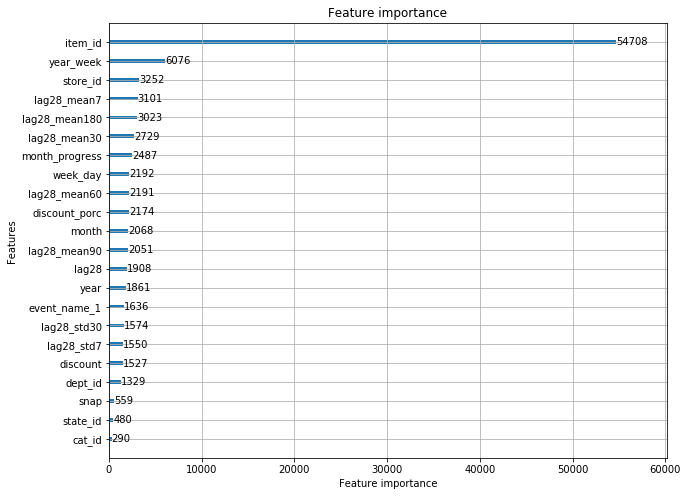

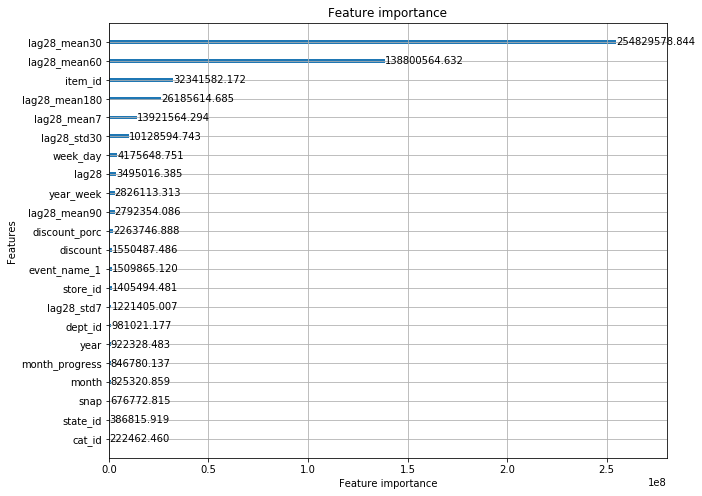

In [14]:
models = list()
errors = list()
best_iterations = list()


for i,valid_period in enumerate(valid_periods):
    print(f" {i+1}/{len(valid_periods)} ".center(100, "#"))
    print(f" Validation period: {valid_period} ".center(100, "#"))
    print("#"*100)
    
    valid_start = valid_period[0]
    valid_end = valid_period[1]
    train_start = valid_start - pd.DateOffset(days=train_history)
        
    _train_data = data.query("@train_start <= ds <= @valid_end").reset_index(drop=True)
    _valid_index = _train_data.query("@valid_start <= ds <= @valid_end").index

    _fcaster = LightGBMForecaster(**model_kwargs)
    _fcaster.prepare_features(train_data=_train_data, valid_index=_valid_index);

    _fcaster.train_features = reduce_mem_usage(_fcaster.train_features)
    _fcaster.valid_features = reduce_mem_usage(_fcaster.valid_features)

    _fcaster.fit(fit_kwargs={"verbose_eval":20})

    lgb.plot_importance(_fcaster.model.model, importance_type="split", figsize=(10,8))
    lgb.plot_importance(_fcaster.model.model, importance_type="gain", figsize=(10,8))
    
    models.append(_fcaster)
    errors.append(_fcaster.model.model.best_score["valid_0"]["rmse"])
    best_iterations.append(_fcaster.best_iteration)

In [15]:
print(np.mean(errors))

2.3484440945085123


In [11]:
print(np.mean(errors))

2.3654164422969934


In [21]:
print(np.mean(errors))

2.3596726179970524


In [22]:
# best error: 2.3596726179970524

***
### final model

In [16]:
model_kwargs["model_params"]["num_iterations"] = best_iterations[0]
model_kwargs["model_params"]

{'objective': 'poisson',
 'metric': 'rmse',
 'num_iterations': 1593,
 'early_stopping_rounds': 200,
 'num_leaves': 63,
 'learning_rate': 0.05,
 'feature_fraction': 0.9,
 'bagging_fraction': 0.66,
 'bagging_freq': 1,
 'lambda_l2': 0.1,
 'seed': 19}

In [17]:
train_start = data.ds.max() - pd.DateOffset(days=train_history)
train_data = data.query("ds >= @train_start").reset_index(drop=True)

In [ ]:
fcaster = LightGBMForecaster(**model_kwargs)
fcaster.prepare_features(train_data=train_data);
fcaster.train_features = reduce_mem_usage(fcaster.train_features)
fcaster.fit(fit_kwargs={"verbose_eval":20})

In [ ]:
lgb.plot_importance(fcaster.model.model, importance_type="split", figsize=(15,10));

In [ ]:
lgb.plot_importance(fcaster.model.model, importance_type="gain", figsize=(15,10));

***
## predicting

In [ ]:
valid_dataframe = pd.read_parquet("../input/valid_dataframe.parquet")
eval_dataframe = pd.read_parquet("../input/eval_dataframe.parquet")
hierarchy = pd.read_parquet("../input/hierarchy.parquet")
submission = pd.read_csv("../input/sample_submission.csv")

***
### predictions for validation period

In [ ]:
#valid_dataframe = pd.merge(valid_dataframe, ts_stats, how="left")

In [ ]:
predictions_valid = pd.merge(fcaster.predict(valid_dataframe), 
                             hierarchy.loc[:, ["id", "item_id", "store_id"]], 
                             how="left")
predictions_valid["id"] = predictions_valid.id.map(lambda x: x+"_validation")

In [ ]:
predictions_valid.y_pred.describe()

In [ ]:
plt.figure(figsize=(15,5))
sns.distplot(predictions_valid.query("y_pred < 10").y_pred.values, kde=False, norm_hist=True)
plt.title("forecast distribution on validation period")
plt.grid()

In [ ]:
predictions_valid = (predictions_valid
                     .pivot(index="id", columns="ds", values="y_pred")
                     .reset_index()
                     )
predictions_valid.columns = ["id"] + [f"F{i}" for i in range (1,29)]

***
### predictions for evaluation period

In [ ]:
#eval_dataframe = pd.merge(eval_dataframe, ts_stats, how="left")

In [ ]:
predictions_eval = pd.merge(fcaster.predict(eval_dataframe), 
                            hierarchy.loc[:, ["id", "item_id", "store_id"]],
                            how="left")
predictions_eval["id"] = predictions_eval.id.map(lambda x: x+"_evaluation")

In [ ]:
predictions_eval.y_pred.describe()

In [ ]:
plt.figure(figsize=(15,5))
sns.distplot(predictions_eval.query("y_pred < 10").y_pred.values, kde=False)
plt.title("forecast distribution on evaluation period")
plt.grid()

In [ ]:
predictions_eval = (predictions_eval
                    .pivot(index="id", columns="ds", values="y_pred")
                    .reset_index()
                   )
predictions_eval.columns = ["id"] + [f"F{i}" for i in range (1,29)]

***
### submission file

In [ ]:
predictions_all = pd.concat([predictions_valid, predictions_eval], ignore_index=True)

In [ ]:
assert set(predictions_all.id) == set(submission.id), \
    "there are missing time series predictions."

In [ ]:
submission = pd.merge(submission.loc[:, ["id"]], predictions_all)

In [ ]:
file_path = "../output/lgbm_bottom_v22.csv.gz"

if os.path.isfile(file_path):
    print("File already exists.")
else:
    submission.to_csv(file_path, index=False, compression="gzip")

In [ ]:
!ls ../output

In [ ]:
!kaggle competitions submit -c m5-forecasting-accuracy -f ../output/lgbm_bottom_v22.csv.gz -m ""

***